In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc

In [2]:
model_path='l/ll'
model_path.replace('/','_')

'l_ll'

In [2]:

data_path = './McDonalds-Yelp-Sentiment-DFE.csv'

train_df = pd.read_csv(data_path, encoding='ISO-8859-1')
print(train_df.shape)
train_df.head(2)

(1525, 10)


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,policies_violated,policies_violated:confidence,city,policies_violated_gold,review
0,679455653,False,finalized,3,2/21/15 0:36,RudeService\rOrderProblem\rFilthy,1.0\r0.6667\r0.6667,Atlanta,NaN,"I'm not a huge mcds lover, but I've been to be..."
1,679455654,False,finalized,3,2/21/15 0:27,RudeService,1,Atlanta,NaN,Terrible customer service. Î¾I came in at 9:30...


In [3]:
import pandas as pd

policy_set = {'ScaryMcDs', 'BadFood', 'Filthy', 'RudeService', 'MissingFood', 'Cost', 'OrderProblem', 'SlowService'}

for policy in policy_set:
    train_df[policy] = 0

# 遍历每一行，根据policy更新a和b列的值
for index, row in train_df.iterrows():
    policy_items = str(row['policies_violated']).split('\r')  # 将字符串转换为list，防止NaN值
    for policy in policy_items:
        if policy in policy_set:
            train_df.at[index, policy] = 1
        elif policy == 'na' or policy == 'nan':
            continue
        else:
            print('Unseen policy', policy)

column_list = list(policy_set)+['review']
# 创建新的DataFrame，仅包含需要的列
train_df = train_df[column_list]

# 将新的DataFrame存储为CSV文件
train_df.to_csv('./res_data.csv', index=False)

In [4]:
# preprocessing
def clean_review(text):
    text = text.split()
    text = [x.strip() for x in text]
    text = [x.replace('\n', ' ').replace('\t', ' ') for x in text]
    text = ' '.join(text)
    text = re.sub('([.,!?()])', r' \1 ', text)
    return text
    

def get_texts(df):
    texts = 'multilabel classification: ' + df['review'].apply(clean_review)
    texts = texts.values.tolist()
    return texts


def get_labels(df):
    labels_li = [' '.join(x.lower().split()) for x in df.columns.to_list()[:8]]
    labels_matrix = np.array([labels_li] * len(df))

    mask = df.iloc[:, :8].values.astype(bool)
    labels = []
    for l, m in zip(labels_matrix, mask):
        x = l[m]
        if len(x) > 0:
            labels.append(' , '.join(x.tolist()) + ' </s>')
        else:
            labels.append('none </s>')
    return labels

texts = get_texts(train_df)
labels = get_labels(train_df)

for text, label in zip(texts[:5], labels[:5]):
    print(f'TEXT -\t{text}')
    print(f'LABEL -\t{label}')
    print()

TEXT -	multilabel classification: I'm not a huge mcds lover ,  but I've been to better ones .  This is by far the worst one I've ever been too !  It's filthy inside and if you get drive through they completely screw up your order every time !  The staff is terribly unfriendly and nobody seems to care . 
LABEL -	orderproblem , rudeservice , filthy </s>

TEXT -	multilabel classification: Terrible customer service .  Î¾I came in at 9:30pm and stood in front of the register and no one bothered to say anything or help me for 5 minutes .  Î¾There was no one else waiting for their food inside either ,  just outside at the window .  Î¾ I left and went to Chickfila next door and was greeted before I was all the way inside .  This McDonalds is also dirty ,  the floor was covered with dropped food .  Obviously filled with surly and unhappy workers . 
LABEL -	rudeservice </s>

TEXT -	multilabel classification: First they "lost" my order ,  actually they gave it to someone one else than took 20 min

# Exploratory Data Analysis

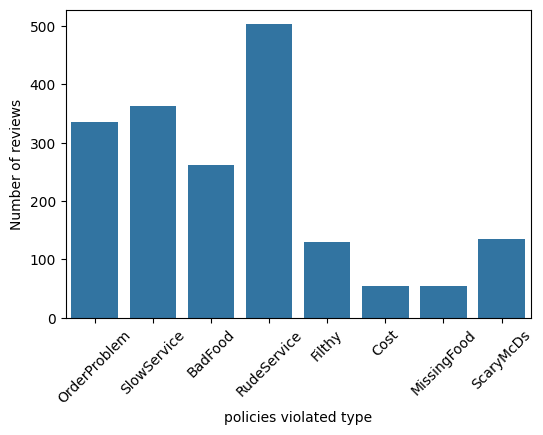

In [5]:
# no. of samples for each class
categories = train_df.columns.to_list()[:8]
plt.figure(figsize=(6, 4))

ax = sns.barplot(x=categories, y=train_df.iloc[:, :8].sum().values)
plt.ylabel('Number of reviews')
plt.xlabel('policies violated type')
plt.xticks(rotation=45)
plt.show()

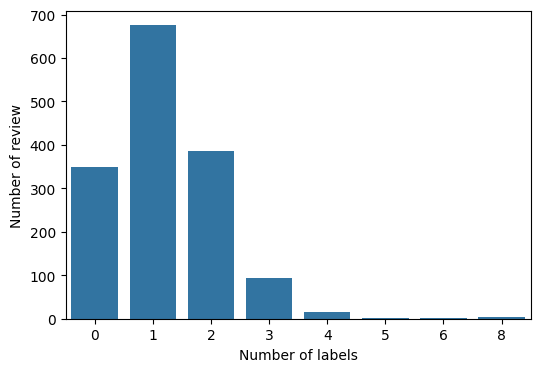

In [6]:
# no of samples having multiple labels
row_sums = train_df.iloc[:, :8].sum(axis=1)
multilabel_counts = row_sums.value_counts()

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=multilabel_counts.index, y=multilabel_counts.values)
plt.ylabel('Number of review')
plt.xlabel('Number of labels')
plt.show()

<BarContainer object of 1525 artists>

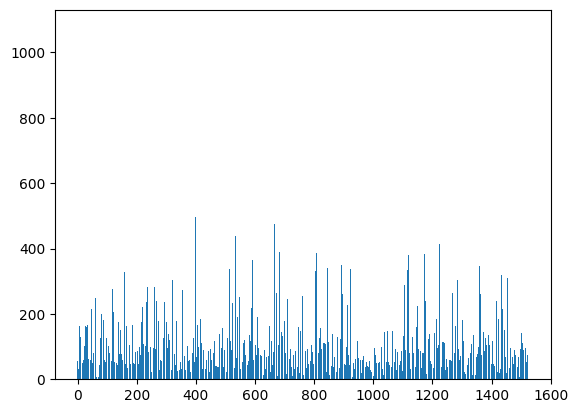

In [7]:
# text lengths
y = [len(t.split()) for t in texts]
x = range(0, len(y))
plt.bar(x, y)

<BarContainer object of 1525 artists>

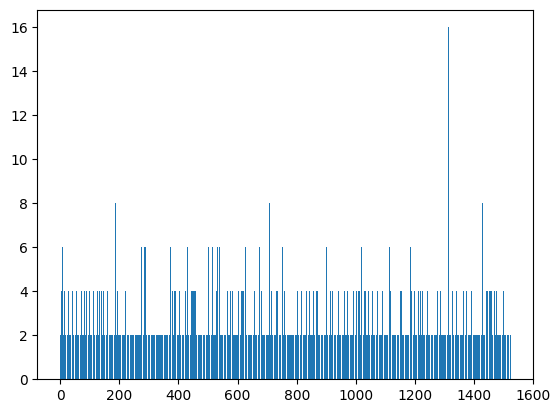

In [8]:
# label lengths
y = [len(l.split()) for l in labels]
x = range(0, len(y))
plt.bar(x, y)